In [1]:
import numpy as np
import pandas as pd
from bayestme import data, deconvolution, plotting
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

In [2]:
data_path = '/Users/hrzhang/Documents/projects/SpatialTranscriptomics/SGE/python/'
Observation = np.load(os.path.join(data_path, 'semi_syn_melanoma_3.npy'))
pos_ss = np.load(os.path.join(data_path, 'melanoma_pos.npy'))

In [3]:
n_spots = Observation.shape[0]
n_gene = Observation.shape[1]
gene_names = np.arange(Observation.shape[1]).astype(str)

stdata = data.create_anndata_object(counts=Observation, 
                                    coordinates=pos_ss.T, 
                                    tissue_mask=np.ones(n_spots).astype(bool),
                                    gene_names=gene_names, 
                                    layout=data.Layout.SQUARE)
stdata = data.SpatialExpressionDataset(stdata)

/Users/hrzhang/anaconda3/lib/python3.8/site-packages/bayestme-0.1.0-py3.8.egg/bayestme/data.py:68: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(counts, obsm={SPATIAL_ATTR: coordinates})


In [4]:
np.random.seed(0)
rng = np.random.default_rng(1)
deconvolution_result = deconvolution.deconvolve(reads=stdata.reads,
                                                edges=stdata.edges,
                                                n_gene=None,
                                                n_components=3,
                                                lam2=1000,
                                                n_samples=100,
                                                n_burnin=1000,
                                                n_max=50,
                                                n_thin=5,
                                                bkg=False,
                                                lda=False,
                                                rng=rng)

Deconvolution: 100%|████████████████████████| 1500/1500 [02:37<00:00,  9.54it/s]


In [5]:
Truth_phi = np.load(os.path.join(data_path, 'semi_syn_melanoma_3_Truth_phi.npy'))
celltype_order = deconvolution_result.align_celltype(Truth_phi)

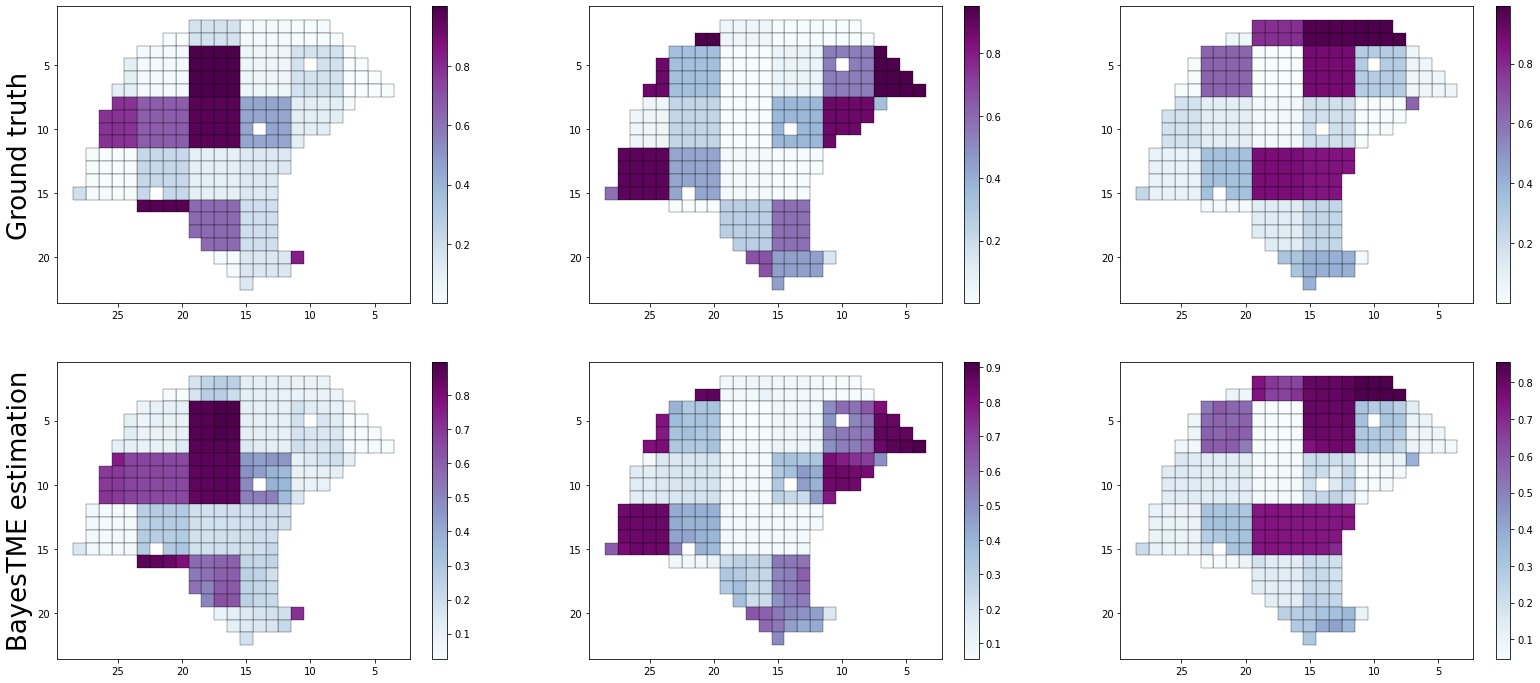

In [6]:
n_components = 3
n_row = 2
fig, ax = plt.subplots(n_row, n_components, figsize=(9*n_components, 6*n_row))
# Ground truth cell type proportion
Truth_prior = np.load(os.path.join(data_path, 'semi_syn_melanoma_3_Truth_prior.npy'))
# BayesTME estimation cell type proportion
post_prob = deconvolution_result.cell_prob_trace[:, :, 1:].mean(axis=0)[:, celltype_order]

for k in range(n_components):
    plotting.plot_colored_spatial_polygon(fig, ax[0, k], pos_ss[::-1].T, Truth_prior[:, k], data.Layout.SQUARE)
    ax[0, k].invert_xaxis()
    ax[0, k].invert_yaxis()
    plotting.plot_colored_spatial_polygon(fig, ax[1, k], pos_ss[::-1].T, post_prob[:, k], data.Layout.SQUARE)
    ax[1, k].invert_xaxis()
    ax[1, k].invert_yaxis()
ax[0, 0].set_ylabel('Ground truth', fontsize=26) 
ax[1, 0].set_ylabel('BayesTME estimation', fontsize=26)
plt.show()

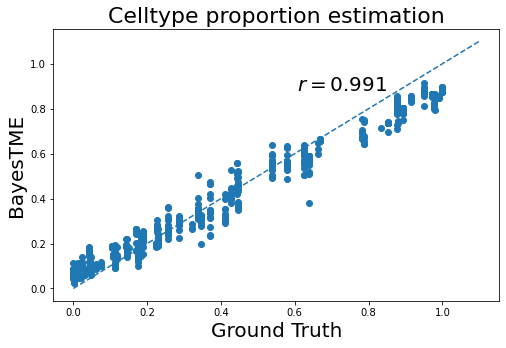

In [7]:
plot_max = Truth_prior.reshape(-1).max() * 1.1

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.scatter(Truth_prior.reshape(-1), post_prob.reshape(-1))
plt.plot([0, plot_max], [0, plot_max], ls='--', c='C0')
prob_r = pearsonr(Truth_prior.reshape(-1), post_prob.reshape(-1))[0]
plt.text(plot_max*0.55, plot_max*0.8, r'$r={:.3f}$'.format(prob_r), fontsize=20)
plt.xlabel('Ground Truth', fontsize=20)
plt.ylabel('BayesTME', fontsize=20)
plt.title('Celltype proportion estimation', fontsize=22)
plt.show()

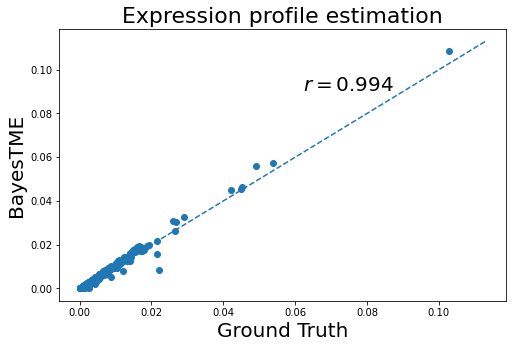

In [8]:
post_phi = deconvolution_result.expression_trace.mean(axis=0)[celltype_order]
plot_max = Truth_phi.reshape(-1).max() * 1.1

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.scatter(Truth_phi.reshape(-1), post_phi.reshape(-1))
plt.plot([0, plot_max], [0, plot_max], ls='--', c='C0')
expression_r = pearsonr(Truth_phi.reshape(-1), post_phi.reshape(-1))[0]
plt.text(plot_max*0.55, plot_max*0.8, r'$r={:.3f}$'.format(expression_r), fontsize=20)
plt.xlabel('Ground Truth', fontsize=20)
plt.ylabel('BayesTME', fontsize=20)
plt.title('Expression profile estimation', fontsize=22)
plt.show()

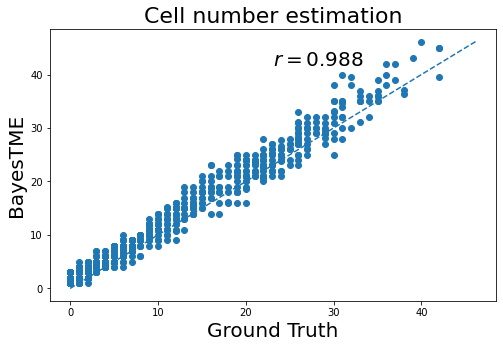

In [9]:
post_ncell = deconvolution_result.cell_num_trace[:, :, 1:].mean(axis=0)[:, celltype_order]
Truth_ncells = np.load(os.path.join(data_path, 'semi_syn_melanoma_3_Truth_ncells.npy'))
plot_max = Truth_ncells.reshape(-1).max() * 1.1

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.scatter(Truth_ncells.reshape(-1), post_ncell.reshape(-1))
plt.plot([0, plot_max], [0, plot_max], ls='--', c='C0')
ncell_r = pearsonr(Truth_ncells.reshape(-1), post_ncell.flatten())[0]
plt.text(plot_max*0.5, plot_max*0.9, r'$r={:.3f}$'.format(ncell_r), fontsize=20)
plt.xlabel('Ground Truth', fontsize=20)
plt.ylabel('BayesTME', fontsize=20)
plt.title('Cell number estimation', fontsize=22)
plt.show()